### Notebook to Create Climatologies

This exercise will show you how to download model results from the ERDDAP server, create a climatology, and compare current results to the climatology.

**Learning Goals**

After completing these exercises you will be able to:
1. describe what a climatology is and explain how you generate one
2. describe anomalies from a climatology and explain how to create them
3. for one tracer field, describe how 2024 compares to previous Mays, considering anomalies and also how large those anomalies are

# 1. Imports and other Set-up

In [13]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [33]:
# color maps, including masking land as grey
cm_haline = copy.copy(cm.haline)
cm_haline.set_bad('grey')
cm_balance = copy.copy(cm.balance)
cm_balance.set_bad('grey')
cm_matter = copy.copy(cm.matter)
cm_matter.set_bad('grey')

In [3]:
# point to the ERDDAP server and the specific data sets we will use
server = "https://salishsea.eos.ubc.ca/erddap"
protocol = 'griddap'
dataset_ids = {"grid": "ubcSSn3DMeshMaskV21-08", 
               "bathymetry": "ubcSSnBathymetryV21-08", 
               "physics": "ubcSSg3DPhysicsFields1hV21-11"}

# 2. Grid and Bathymetry

In [6]:
# get grid information
full_URL = '/'.join([server,protocol,dataset_ids['grid']])
print(full_URL)
mesh = xr.open_dataset(full_URL)
tmask = mesh.tmask[0].values
mesh.close()

https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV21-08


In [8]:
# get bathymetry information
full_URL = '/'.join([server,protocol,dataset_ids['bathymetry']])
print(full_URL)
bathy = xr.open_dataset(full_URL)

https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV21-08


In [18]:
# choose region of interest in model grid points
ygmin, ygmax = 700, 800
xgmin, xgmax = 110, 210
# region for profile
xcmin, xcmax = 120, 160
sy = 725

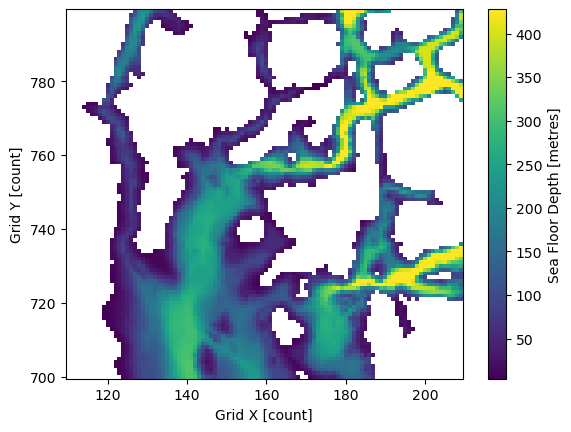

In [19]:
# plot bathymetry
bathy.bathymetry[ygmin:ygmax, xgmin:xgmax].plot();

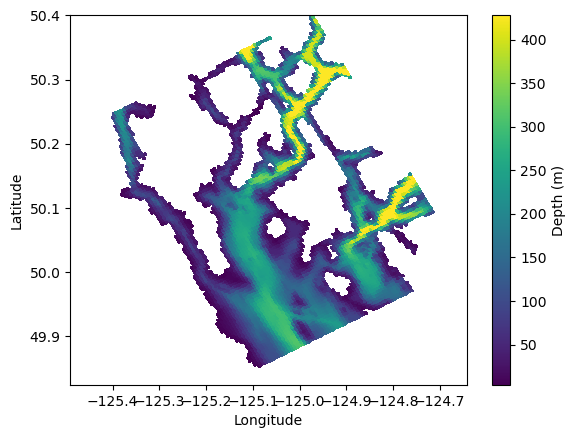

In [17]:
# latitude, longitude plot
fig, ax = plt.subplots(1, 1)
colours = ax.pcolormesh(bathy.longitude[ygmin:ygmax, xgmin:xgmax], bathy.latitude[ygmin:ygmax, xgmin:xgmax],
              bathy.bathymetry[ygmin:ygmax, xgmin:xgmax]);
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
cb = fig.colorbar(colours, ax=ax);
cb.set_label('Depth (m)');

## Exercise  
Choose one of: (in consultation with the class so we get a bunch done!)
* surface salinity
* surface temperature
* surface nitrate
* depth integrated diatoms
* depth integrated flagellates
* vertical cross-section of salinity***
* vertical cross-section of temperature
* vertical cross-section of oxygen
* vertical cross section of dissipation

Build a daily climatology for your field for May 15.  Calculate the anomalies for 2024.  Calculate the standard deviation over the time series.  Determine is the anomalies are significant.

Below I give an example, for a vertical cross-section of salinity (for May 11 as May 15 hasn't happened yet!).

In [20]:
full_URL = '/'.join([server,protocol,dataset_ids['physics']])
print(full_URL)
phys = xr.open_dataset(full_URL)

https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DPhysicsFields1hV21-11


In [21]:
# get the dates we want, note model time series starts in 2007
datelist = [f'{year}-05-11T20:30:00' for year in range(2007, 2024+1)]
datelist

['2007-05-11T20:30:00',
 '2008-05-11T20:30:00',
 '2009-05-11T20:30:00',
 '2010-05-11T20:30:00',
 '2011-05-11T20:30:00',
 '2012-05-11T20:30:00',
 '2013-05-11T20:30:00',
 '2014-05-11T20:30:00',
 '2015-05-11T20:30:00',
 '2016-05-11T20:30:00',
 '2017-05-11T20:30:00',
 '2018-05-11T20:30:00',
 '2019-05-11T20:30:00',
 '2020-05-11T20:30:00',
 '2021-05-11T20:30:00',
 '2022-05-11T20:30:00',
 '2023-05-11T20:30:00',
 '2024-05-11T20:30:00']

In [22]:
# pullout the field we want, and only the space we want (small is good, you can make it bigger later)
sal = phys['salinity'].sel(  
                  gridX=slice(xcmin, xcmax),  
                  gridY=sy, 
                  time=datelist,
                  depth=slice(0, 300), 
                 )

In [24]:
print (sal.shape)
lk = sal.shape[1]  # this figures out how many depth levels I have given my depth choice above
smask = tmask[:lk, sy, xcmin:xcmax+1]  # create a mask of the land

(18, 34, 41)


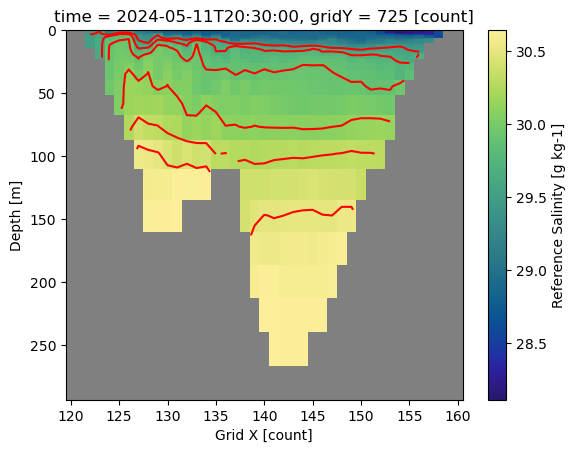

In [25]:
# plot the 2024 field
sal[-1].where(smask).plot(yincrease=False, cmap=cm_haline);
sal[-1].where(smask).plot.contour(yincrease=False, levels=np.arange(29.5, 30.8, 0.2), colors='red');

In [27]:
# create the climatology (not including 2024)
sal_climatology = sal[:-1].mean(axis=0)

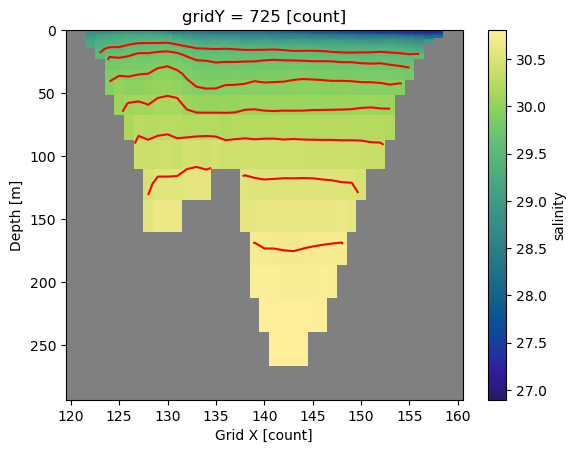

In [28]:
sal_climatology.where(smask).plot(yincrease=False, cmap=cm_haline);
sal_climatology.where(smask).plot.contour(yincrease=False, levels=np.arange(29.5, 30.8, 0.2), colors='red');

## Question 1.

a) What do you see your field, what type of patterns?  
*For example, in my salinity cross-section, I see that near the surface there is fresher water on the east side of the cross-section.  This pattern makes sense because there is more freshwater coming off the mainland than the east side of Vancouver Island.  In addition, looking in particular at the climatology, there is change in salinity at mid-depths at about grid point 132 with the water to the west saltier than the water to the east.*  
b) Why is the 2024 plot "noiser" than the climatology?  

You could plot the 2024 field side by side with the climatology to better see the differences.  However, an even better way to show the differences is to subtract them.  The **anomalies** are the 2024 field minus the climatology.

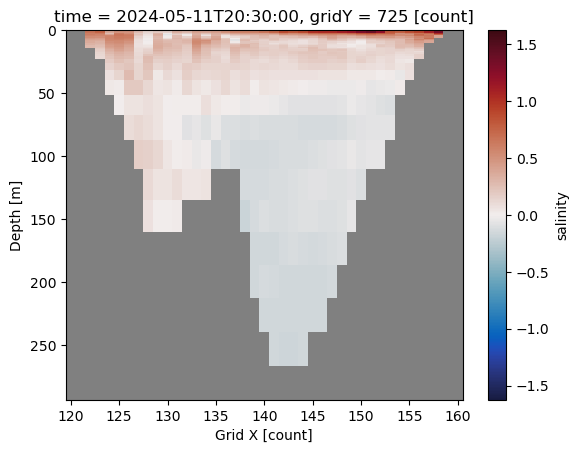

In [31]:
# plot the anomalies
(sal[-1] - sal_climatology).where(smask).plot(yincrease=False, cmap=cm_balance);

## Question 2.

a) How does 2024 compare to the climatology for your field?  
*For example, my salinity anomalies show that 2024 was saltier at the surface and at all depths on the western side.  Deep on the eastern side though, it is fresher than usual.  That means, on the east side, the stratification is weaker than usual.  
b) What do you think it is different (what processes might be stronger/weaker)?  

To ask how anomalous this year is, for each spatial point we calculate a standard deviation over the time series.

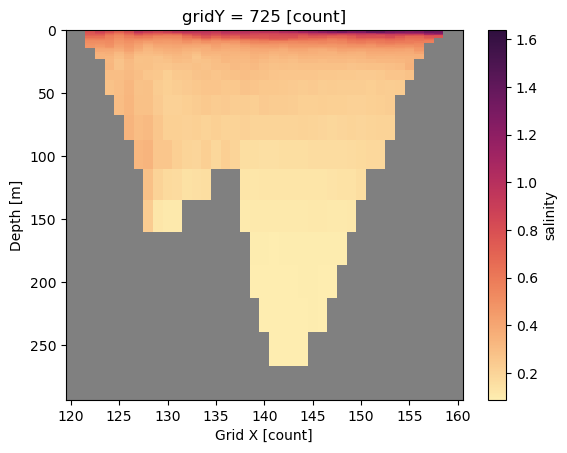

In [34]:
# Calculate the Standard Deviation
sal_std = sal[:-1].std(axis=0)
sal_std.where(smask).plot(yincrease=False, cmap=cm_matter);

## Question 3.

a) Can you explain the regions of high standard deviation?  What processes make them higher?

To look at how anomalous 2024 was, we can ask how many standard deviations is it from the mean?  Two is high, three is very high.

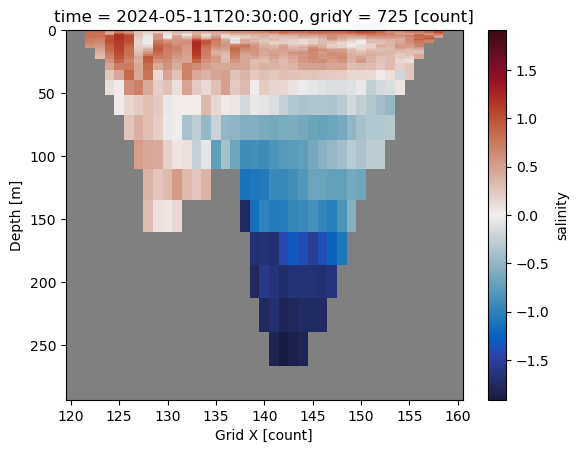

In [35]:
((sal[-1] - sal_climatology)/sal_std).where(smask).plot(yincrease=False, cmap=cm_balance);

## Question 4.

a) For your field, how high are the anomalies?

Lastly we will ask if any other years look like 2024.  Here I am going to plot the normalized anomalies (divided by the standard deviation, but you can choose what to look at: the raw field, the anomalies or the normalized anomalies.

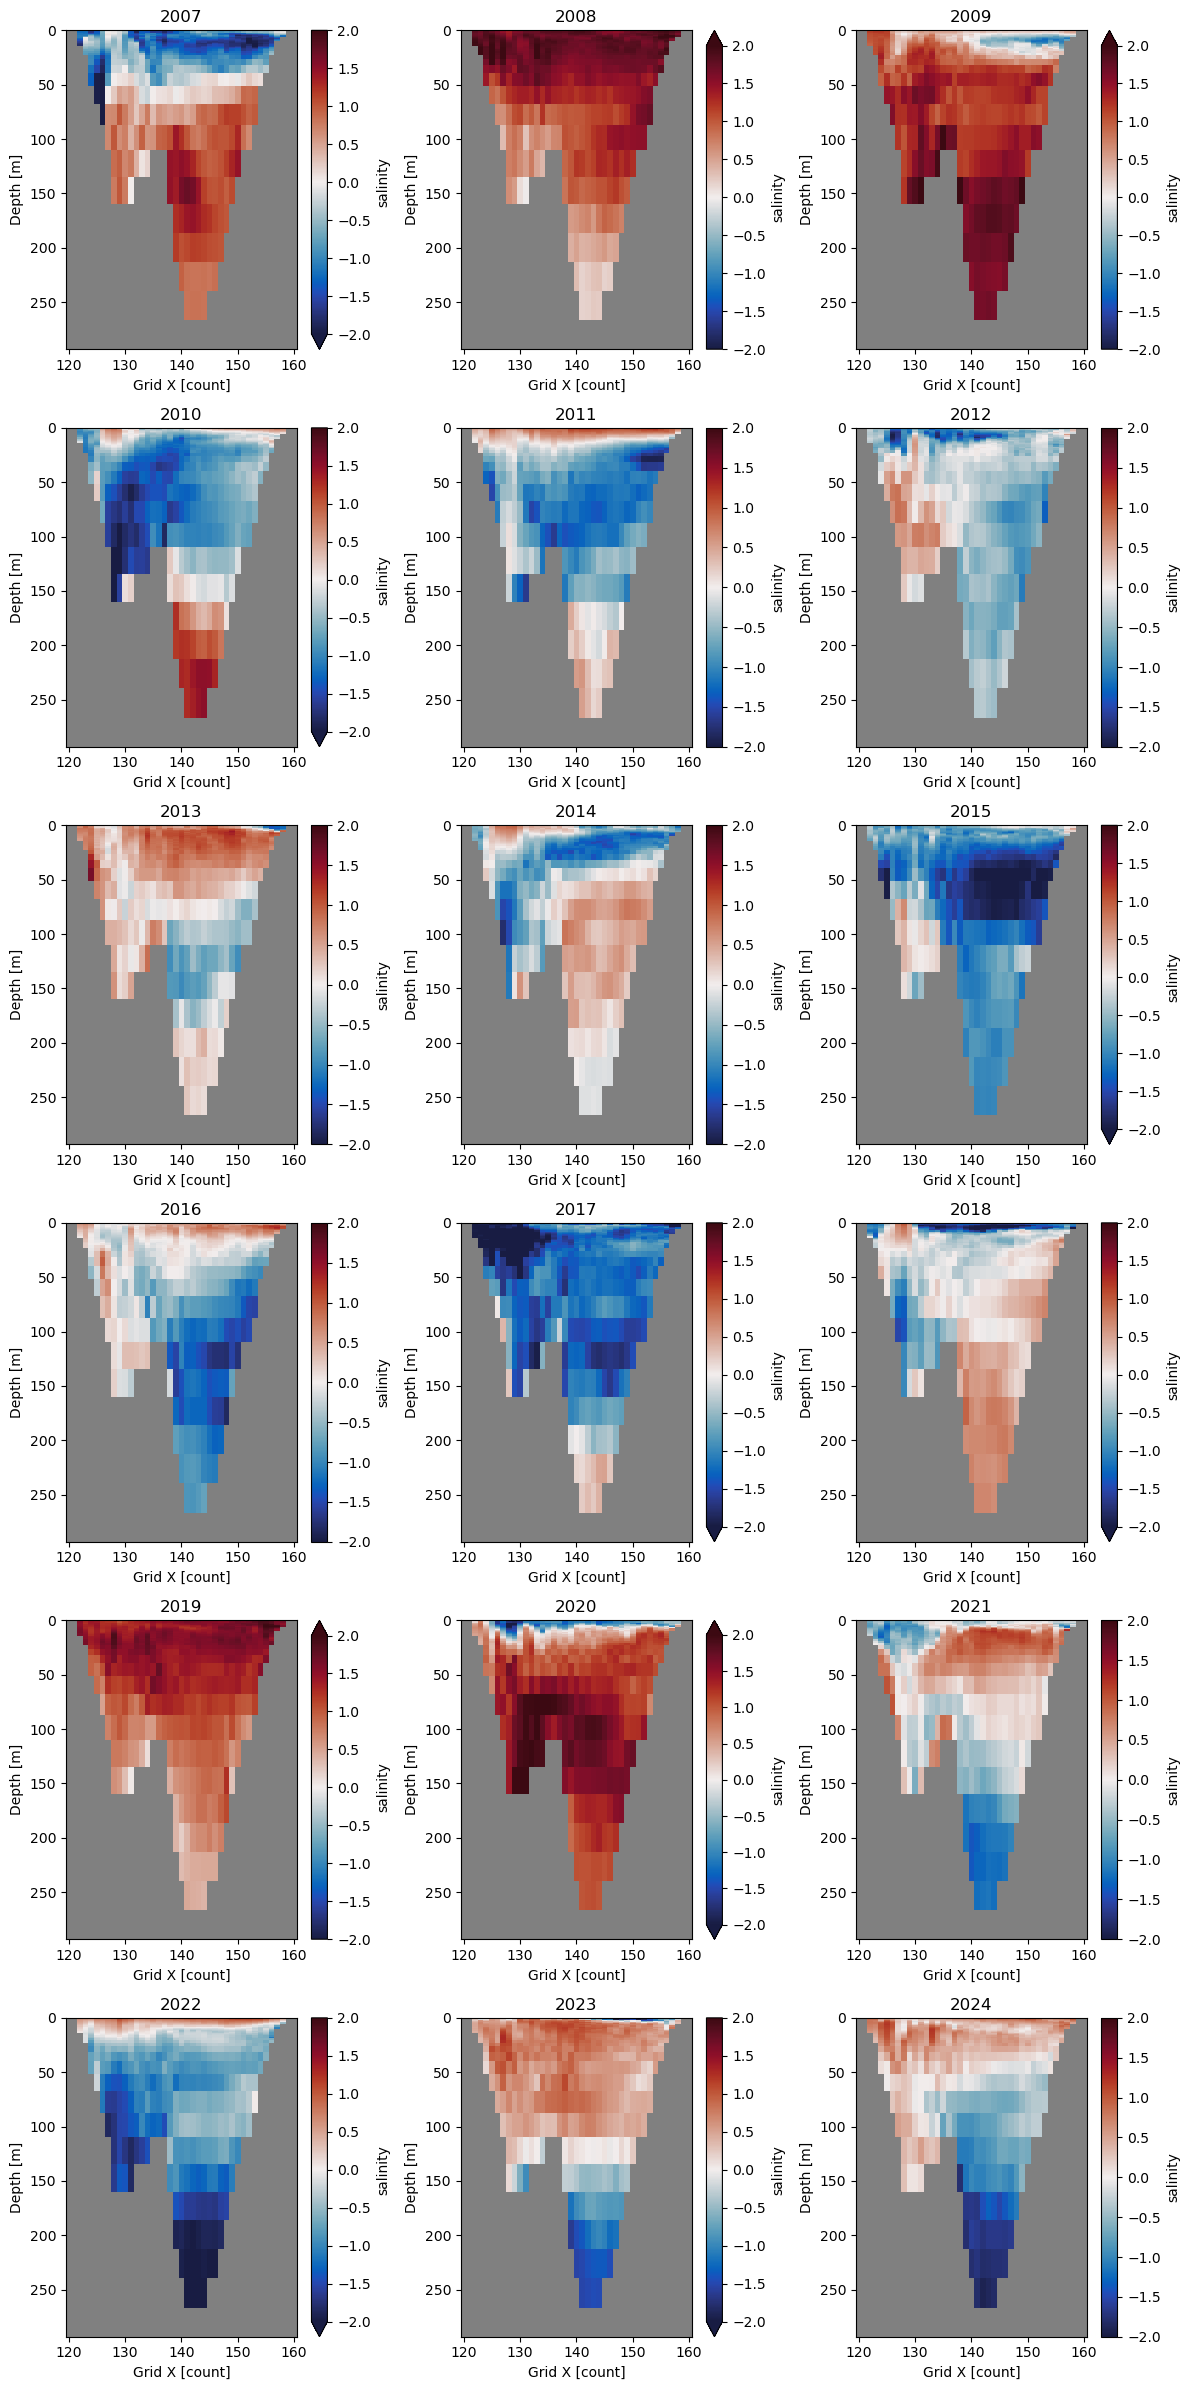

In [41]:
fig, axs = plt.subplots(6, 3, figsize=(12, 24))

ii = 0
jj = 0

for ic, year in enumerate(range(2007, 2024+1)):
    ((sal[ic] - sal_climatology)/sal_std).where(smask).plot(ax=axs[ii, jj], yincrease=False, cmap=cm_balance,
                                                           vmax=2, vmin=-2);
    axs[ii, jj].set_title(year)
    if jj < 2:
        jj = jj + 1
    else:
        jj = 0
        ii = ii + 1
fig.tight_layout();

## Question 5.

a) For your field, does 2024 look like any of the other years?